In [24]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Flatten, Dense, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

In [2]:
def normalize(data): 
    for i in data.columns:
        data[i] = (data[i] - np.mean(data[i]))/np.std(data[i])
    return np.nan_to_num(data)

In [19]:
#Concatenate positive and negative samples
trainFull = pd.read_csv("PreprocessedData/trainFull.csv")
testFull = pd.read_csv("PreprocessedData/testFull.csv")

trainFull = trainFull.sample(frac = 1)
testFull = testFull.sample(frac = 1)
    
#Reduce features and extract labels
trainX = trainFull.iloc[:,:-2]
trainY = trainFull.iloc[:,-1]
testX = testFull.iloc[:,:-2]
testY = testFull.iloc[:,-1]

trainX = normalize(trainX)
testX = normalize(testX)

#Reshape data to 3D for CNN

trainX = trainX[..., None]
trainY = trainY.to_numpy()[..., None]
testX = testX[..., None]
testY = testY.to_numpy()[..., None]


In [28]:
def newModel(numConvFilters = 242, dropout = .215, numDenseNodes = 190):
    #Create new sequential model
    model = Sequential()

    #Add 1D Convolutional layers
    model.add((Conv1D(filters=32, kernel_size=3, activation='relu')))
    model.add((Conv1D(filters=numConvFilters, kernel_size=3, activation='relu')))
    #Add Max Pooling layer
    model.add((MaxPooling1D(pool_size=2)))
    #Apply dropout
    model.add(Dropout(dropout))
    #Flatten model
    model.add(Flatten())
    #Add fully connected dense layer
    model.add(Dense(numDenseNodes, activation='sigmoid'))
    #Add output node
    model.add(Dense(1, activation='sigmoid'))
    
    #Define optimizer
    adam = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #Compile model
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve='PR'),   
                                                                       tf.keras.metrics.PrecisionAtRecall(0.8)])
    return model

In [25]:
model = newModel()
model.fit(trainX, trainY, epochs = 30, batch_size=20, verbose = 1)

Epoch 1/30
758/758 [==============================] - 24s 29ms/step - loss: 0.5767 - auc_4: 0.7642 - precision_at_recall_4: 0.6512
Epoch 2/30
758/758 [==============================] - 24s 32ms/step - loss: 0.5338 - auc_4: 0.8111 - precision_at_recall_4: 0.6920
Epoch 3/30
758/758 [==============================] - 30s 40ms/step - loss: 0.5132 - auc_4: 0.8292 - precision_at_recall_4: 0.7028
Epoch 4/30
758/758 [==============================] - 34s 44ms/step - loss: 0.4988 - auc_4: 0.8411 - precision_at_recall_4: 0.7109
Epoch 5/30
758/758 [==============================] - 36s 48ms/step - loss: 0.4821 - auc_4: 0.8516 - precision_at_recall_4: 0.7327 0s - loss: 0.4817 - auc_4: 0.8518 - precision_at_recall_4
Epoch 6/30
758/758 [==============================] - 27s 36ms/step - loss: 0.4699 - auc_4: 0.8608 - precision_at_recall_4: 0.7439
Epoch 7/30
758/758 [==============================] - 20s 26ms/step - loss: 0.4565 - auc_4: 0.8702 - precision_at_recall_4: 0.7600
Epoch 8/30
758/758 [=====

In [26]:
#create confusion Matrix
def confusionMatrix(model, testX, testY):
    pred = model.predict(testX)
    predy = []
    for i in range(0,len(pred)):
        if pred[i] >= .5:
            predy.append(1)
        else:
            predy.append(0)
        
    print(confusion_matrix(testY,predy))
    
#Calculates our model metrics
def modelMetrics(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    rec80 = np.max(recall[precision >= .8])
    print("Recall at 80% Precision: " +str(rec80))
    aucPR = auc(recall, precision)
    print("PR-AUC: " + str(aucPR))
    
    return rec80, aucPR, 

#plots a PR curve
def PRplot(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    plt.plot(recall, precision)
    plt.title("PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

Recall at 80% Precision: 0.8775725593667546
PR-AUC: 0.9152249555017694
[[1553  342]
 [ 299 1596]]


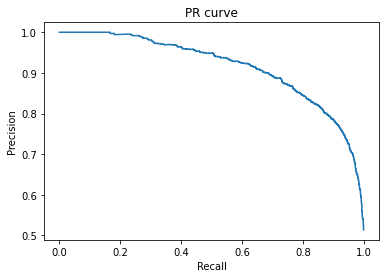

In [27]:

modelMetrics(testX, testY, model)
confusionMatrix(model, testX, testY)
PRplot(testX, testY, model)